In [1]:
import os

# Define the new working directory relative to the current working directory
new_working_directory = os.path.join(os.getcwd(), '..', '..', '..') # Set to MLAgentBenhc
print("New working directory: ", new_working_directory)

# Change the current working directory
os.chdir(new_working_directory)
print("New Working Directory:", os.getcwd()) # Should be ...\MLAgentBench

New working directory:  c:\Users\kevihuang\OneDrive - Microsoft\Desktop\projects\MLAgentBench\MLAgentBench_v2\agents\Eureka\..\..\..
New Working Directory: c:\Users\kevihuang\OneDrive - Microsoft\Desktop\projects\MLAgentBench


In [2]:
# General Environment and Agent imports
from MLAgentBench_v2.agents.agent import Agent
from types import SimpleNamespace
from MLAgentBench_v2.environment import Environment
from datetime import date

# Agent specific imports
import json
import matplotlib.pyplot as plt

No module named 'helm'
Could not load CRFM API key crfm_api_key.txt.
[Errno 2] No such file or directory: 'claude_api_key.txt'
Could not load anthropic API key claude_api_key.txt.
[Errno 2] No such file or directory: 'openai_api_key.txt'
Could not load OpenAI API key openai_api_key.txt.


In [3]:
# Instantiate an environment
TASK = 'home-data-for-ml-course'
MODEL = 'gpt-3.5-turbo-0125'
AGENT_NAME = 'eureka-v2'
VERSION = '0'
RESEARCH_PROBLEM = '''Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Evaluation
Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

You want a train and validation MAE of lower than 11,000 and there should be a submission.csv containing predictions for test.csv ready to submit.

Metric
Submissions are evaluated on Mean-Absolute-Error (MAE) between the predicted value and the observed sales price.

Submission File Format
The file should contain a header and have the following format:

Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.''' # Manually define the goal for the agent based on Kaggle competition description

env = Environment(SimpleNamespace(
    task=TASK,
    task_type='kaggle',
    log_dir=f'logs/{date.today().strftime("%Y-%m-%d")}__{TASK}__{AGENT_NAME}__{MODEL}__v{VERSION}', # date__task__agent__llm__version
    work_dir='workspace',
    llm_name=MODEL,
    research_problem=RESEARCH_PROBLEM
))

--- Initializing environment ---
--- Environment args ---
 namespace(task='home-data-for-ml-course', task_type='kaggle', log_dir='logs/2024-05-05__home-data-for-ml-course__eureka-v2__gpt-3.5-turbo-0125__v0', work_dir='workspace', llm_name='gpt-3.5-turbo-0125', research_problem="Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.\n\nWith 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.\n\nEvaluation\nGoal\nIt is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. \n\nYou want a train and validation MAE of lower than 11,000 and there shoul

In [7]:
# Instantiate the agent
class EurekaAgent(Agent):
    def __init__(self, env, round_idx=None):
        super().__init__(env)
        self.env = env # allows you to interact with the environment using debug_agent.env
        self.num_runs = 1 # number of runs to sample

        if round_idx:
            with open(f'{self.work_dir}/eureka/eval_over_time_{round_idx}.json', 'r') as f:
                self.eval_over_time = json.load(f)
        elif os.path.exists(f'{self.work_dir}/eureka/eval_over_time.json'):
            with open(f'{self.work_dir}/eureka/eval_over_time.json', 'r') as f:
                self.eval_over_time = json.load(f)    
        else:
            self.eval_over_time = []

        self.latest_best_MAE_code = ""
        self.best_MAE_std_out = ""

    def get_initial_hypotheses_and_results(self):
        '''Get initial hypotheses and results for the agent to start with.'''

        self.system_prompt_initial = f'''You are a machine learning engineer trying to write machine learning code to solve machine learning tasks as effectively as possible.

Your goal is to write a machine learning script for the environment that will help the model achieve the highest accuracy possible on the research task described in text. 

For evaluation, ensure that the machine learning script outputs the validation MAE.

Tips:
1) Note that your code and outputs will be iterated upon so feel free to add information (comments, print statements) that may provide more information to get a better iterated code next time after looking at the executed code and outputs.
2) Ensure that you are calculating the validation MAE from a validation set and not the training set. This may require splitting the training set into a training and validation set if a validation set doesn't exist.

I will give you the following information:
Research task: ...
Files: these are the current files you have in your working directory to work with

The output format must be only executable python code, no conversation or explanation.
'''
        self.user_prompt_initial = f'''
Research task: {self.research_problem}
Files: {str(os.listdir(self.work_dir))}
'''
        files = str(os.listdir(self.work_dir))
        print("\nSystem prompt: \n" + self.system_prompt_initial)
        print("\nUser prompt: \n" + self.user_prompt_initial)

        complete_task_args = {
            'system_prompt': self.system_prompt_initial,
            'user_prompt': self.user_prompt_initial,
            'max_tokens': 4096,
            'temperature': 1.0, # increase randomness as much as possible
            'top_p': 1.0,
        }

        # Track raw results and MAE results
        mae_results, raw_results_after_script_execution, sorted_index_mae_results = self.sample_run_eval_actions(complete_task_args, files)
        return mae_results, raw_results_after_script_execution, sorted_index_mae_results
        
        
    def reward_reflection_and_feedback(self):
        '''Iterate on the best MAE code and output to provide feedback and generate new code.'''

        # best MAE can be taken from eval_over_time which already contains them sorted
        best_MAE_run_idx = None
        min_MAE_value = float('inf')
        
        # Iterate in reverse order to find the largest index with the minimum value (in case some code just added debugging)
        for idx, sublist in enumerate(reversed(self.eval_over_time)):
            current_MAE_value = float(sublist[0][1])
            if current_MAE_value <= min_MAE_value:
                min_MAE_value = current_MAE_value
                best_MAE_run_idx = len(self.eval_over_time) - 1 - idx
        latest_best_MAE_idx, latest_best_MAE_value = self.eval_over_time[best_MAE_run_idx][0]

        # Get the code and output from the best MAE run
        args = {
            'file_name': f'eureka/run_{best_MAE_run_idx}_script_{latest_best_MAE_idx}.py', 
            'update_files_action_result_history': False
        }
        self.latest_best_MAE_code = f'''{self.available_actions['readFile'](**args)}\n'''
        stdout_args = {
            'file_name': f'eureka/run_{best_MAE_run_idx}_script_{latest_best_MAE_idx}_stdout.txt', 
            'update_files_action_result_history': False
        }
        self.best_MAE_std_out = f'''{self.available_actions['readFile'](**stdout_args)}\n'''

        # First generate feedback for the best MAE code
        best_MAE_feedback = f"Evaluation: \nValidation MAE: {latest_best_MAE_value}"        

        # Not adding feedback for now because this looks like it's stifling progress and not allowing for more diverse iterations
        # generate_feedback_args = {
        #     'system_prompt': "You are a helpful assistant. Please take the following code and evaluation and provide useful feedback on why the code works well and why it doesn't.",
        #     'user_prompt': "Code: \n" + latest_best_MAE_code + "\n" + best_MAE_feedback,
        #     'max_tokens': 4096,
        #     'temperature': 0.0,
        #     'top_p': 0.0,
        #     'update_files_action_result_history': False,
        # }
        # best_MAE_feedback += "\nFeedback: \n" + self.env.complete_text_openai(**generate_feedback_args)

        # Create reward reflection and feedback prompts
        self.system_prompt_initial = f'''You are a machine learning engineer. Your goal is to write a machine learning script for the environment that will achieve the highest accuracy possible on the research task described in text. 
        
We trained a machine learning model using the provided machine learning script and calculated the validation MAE.

Please carefully analyze the script, MAE, research task, and given information and provide a new, improved machine learning script that can potentially better solve the research task.

Tips:
1) Note that your code and outputs will be iterated upon so feel free to add information (comments, print statements) that may provide more information in its output to get a better iterated code next time after looking at the executed code and outputs.
2) Ensure that you are calculating the validation MAE from a validation set and not the training set. This may require splitting the training set into a training and validation set if a validation set doesn't exist.
3) The code you provide must be full and complete because it will be directly run and evaluated.
4) For evaluation, ensure that the machine learning script outputs the validation MAE (not MAE using log values but normal values).
5) When choosing what one option to try to improve the code, if you're just going to add more debugging, then just add it because if the code execution output is greater than or equal to the best code output so far, that'll be updated as the new best code so the output will be used and iterated upon.

I will give you the following information:
Research task: ...
Machine learning script: ...
Output: ...
Files: these are the current files that you have in your working directory to work with
Question 1: ...
Answer: ...
Question 2: ...
Answer: ...
...

The output format should be JSON. 
Example:
```json
{{
    "first_principles_observations": "<insert step by step reasoning about the most useful information you see that is most certain and useful>",
    "things_to_try": "<insert what specifically you could do to improve the code and what potentially promising options might be missing from the machine learning script>",
    "option_to_try": "<insert process of elimination to figure out what one change is the most reasonably better to try to improve current script. Conclude with the single change / thing you're going to try. I need an ablation to know that this singular change caused an improvement or not.>",
    "code": "<insert complete python executable code with improvement made>"
}}
```
'''
        
        self.user_prompt_initial = f'''
Research task: {self.research_problem}
Machine learning script: {self.latest_best_MAE_code}

Output: {self.best_MAE_std_out}
Files: {str(os.listdir(self.work_dir))}
'''
        # self.user_prompt_initial += self.retrieve_qa()
        files = str(os.listdir(self.work_dir))
        print("\nSystem prompt: \n" + self.system_prompt_initial)
        print("\nUser prompt: \n" + self.user_prompt_initial)

        complete_task_args = {
            'system_prompt': self.system_prompt_initial,
            'user_prompt': self.user_prompt_initial,
            'max_tokens': 4096,
            'temperature': 1.0, # increase randomness as much as possible
            'top_p': 1.0,
            'update_files_action_result_history': False,
            'json_required': True,
        }

        # Track raw results and MAE results
        mae_results, raw_results_after_script_execution, sorted_index_mae_results = self.sample_run_eval_actions(complete_task_args, files)
        return mae_results, raw_results_after_script_execution, sorted_index_mae_results 
    

    def retrieve_qa(self):
        # Retrieve QA for the research problem to give the agent more useful information to guide its search

        question_answer_string = ""
        num_questions = 1
        for idx in range(num_questions):
            # First ask for question (iteratively for better search)
            asking_questions_system_prompt = f'''You are a machine learning engineer that asks questions to help me decide the next option to try to improve my machine learning script. My goal is to write a machine learning script for the environment that will achieve the highest accuracy possible on the research task described in text. 

    I will give you the following information:
    Research task: ...
    Machine learning script: ...
    Output: ...
    Files: these are my current files that I have in my working directory.
    Most recent questions and answers: ...

    You must follow the following criteria:
    1) You should ask 1 question to help me figure out the next immediate improvement option to try. The question should be followed by the concept that the question is about. Note that you will be able to ask up to 5 questions, which means that if you don't have 4 "most recent questions and answers", you will be able to ask another question later. My answers may not be the most comprehensive or accurate, but it will be the best I can do so please ask questions that are specific and more likely to guarantee useful information. 
    2) Your question should be specific to a concept in Wikipedia or my memory of what I've tried so far or information about the files and script that you want to know. The question should not be too general.
    Bad example (the question is too general):
    Question: What is the best way to achieve the research goal?
    Concept: unknown
    Good example:
    Question: What are some predictive models that can be used to predict the SalePrice of a house?
    Concept: housing price predictive model
    Good example: 
    Question: What are feature engineering techniques that are good to use for predicting the SalePrice of a house?
    Concept: Housing price predictive model features
    3) Don't ask me questions that take too long to answer. These must be things I can check quickly by searching or trying to remember what I did or run a simple script to check. A bad example is asking me to train a transformer model and seeing what the validation MAE is.

    RESPONSE FORMAT: 
    ```json
    {{ 
        "reasoning": "<reasoning>",
        "question": "<question>",
        "concept": "<concept>"
    }}
    ```

    Ensure the response can be parsed by Python "json.loads", e.g.: no trailing commas, no single quotes, etc. This is important.
    '''

            asking_questions_user_prompt = f'''Research task: {self.research_problem}\nMachine learning script: {self.latest_best_MAE_code}\n\nOutput: {self.best_MAE_std_out}\nFiles: {str(os.listdir(self.work_dir))}\nMost recent questions and answers: {question_answer_string}'''
        
            questions_and_concepts = self.complete_text_openai(system_prompt=asking_questions_system_prompt, user_prompt=asking_questions_user_prompt, json_required=True, update_files_action_result_history=False, temperature=1.0, top_p=1.0, max_tokens = 250) # for faster results, high temperature too
            question_and_concepts_json = json.loads(questions_and_concepts)

            # Answer questions
            answer = input(f"Answer this question: {question_and_concepts_json['question']}") # Manually answer first
            question_answer_string += f"\nQuestion {str(idx + 1)}: {question_and_concepts_json['question']}\n{answer}"

        return question_answer_string

    def sample_run_eval_actions(self, complete_task_args, files=""):
        '''Main run function for running samples and evaluating them.'''
        mae_results = []
        raw_results_after_script_execution = []
        round_idx = len(self.eval_over_time)

        # b) sample self.num_runs different guesses
        for i in range(self.num_runs):
            # 2. Write as a python script and ensure that it's valid python code
            raw_output = self.env.complete_text_openai(**complete_task_args) 
            print("\nRaw output: \n" + raw_output)
            if 'json_required' in complete_task_args and complete_task_args['json_required']:
                try:
                    raw_output = json.loads(raw_output)['code']
                except:
                    print("Error loading json")

            # Take the best linear combination of the code
            max_python_code_args = {
'system_prompt': '''You are a machine learning engineer. Your goal is to analyze what is expected to work well, what you'd do differently for each of the two approaches which are machine learning scripts, and then write an optimal machine learning script that will achieve the highest accuracy possible on the research task described in text using the best parts that you've found.

I will give you the following information:
Research task: ...
Approach / Script 1: ...
Approach / Script 2: ...
Files: these are the current files and its contents that you have in your working directory to work with

Tips:
1) Note that your code and outputs will be iterated upon so feel free to add information (comments, print statements) that may provide more information to get a better iterated code next time after looking at the executed code and outputs.
2) Ensure that you are calculating the validation MAE from a validation set and not the training set. This may require splitting the training set into a training and validation set if a validation set doesn't exist.
3) The code you provide must be full and complete because it will be directly run and evaluated.
4) For evaluation, ensure that the machine learning script outputs the validation MAE (not MAE using log values but normal values).

The output format should be JSON. 
Example:
```json
{
    "approach_1_analysis": "<insert analysis about approach 1>",
    "approach_2_analysis": "<insert analysis about approach 2>",
    "best_pieces_to_form_optimal_code", "<insert analysis about best pieces from combining the best parts of approach 1 and 2 to make the most optimal code>",
    "optimal_code": "<insert complete python executable code that takes the best parts of each approach to create the most expected optimal approach>"
}''',
                'user_prompt': f"Research task: {self.research_problem}\nApproach / Script 1: {self.latest_best_MAE_code}\nApproach / Script 2: {raw_output}\nFiles: {files}",
                'max_tokens': 4096,
                'temperature': 0.0,
                'top_p': 0.0,
                'update_files_action_result_history': False,
                'json_required': True,
            }
            try:
                python_code = json.loads(self.env.complete_text_openai(**max_python_code_args))['optimal_code']
            except:
                python_code = self.env.complete_text_openai(**max_python_code_args)

            write_args = {
                'file_name': f'eureka/run_{round_idx}_script_{i}.py',
                'content': python_code,
                'update_files_action_result_history': False,
            }
            self.available_actions['writeFile'](**write_args)

            # c) Execute file
            execute_args = {
                'script_name': f'eureka/run_{round_idx}_script_{i}.py',
                'update_files_action_result_history': False,
            }
            result = self.env.execute_script(**execute_args)
            write_stdout_args = {
                'file_name': f'eureka/run_{round_idx}_script_{i}_stdout.txt',
                'content': result,
                'update_files_action_result_history': False,
            }
            self.available_actions['writeFile'](**write_stdout_args)
            
            # d) Take the best expected value, save output, code, and an explanation of why it was good, and why it was bad.
            # 1. Use chat_completion to 1) ensure that the code outputs the validation MAE and then 2) extract the validation MAE if it exists.
            # 2. Sort all the results
            # 3. Use chat completion to add more feedback about why the code was good and why it was bad.
            extract_val_MAE_args = {
                'system_prompt': '''You are a helpful assistant. Your goal is to check if the code outputs the validation MAE, specifically not from logged values, but normal values, and make sure that the code for calculating validation MAE is actually from a validation set. If so, then extract the validation MAE value from the result. If the code doesn't output the validation MAE or its not for normal values or the code doesn't actually calculate and print validation MAE from a validation set, then please write "inf" as the validation MAE. Note that if the MAE is below 1, then that's unreasonable and likely from logged values so please write "inf" as the validation MAE.
                
                Example:
                ```json
                {
                    "code_calculates_and_outputs_normal_val_MAE": <boolean>,
                    "val_MAE": <float>
                }''',
                'json_required': True,
                'user_prompt': "Code: " + python_code + "\nResult after executing code: " + result,
                'max_tokens': 4096,
                'temperature': 0.0,
                'top_p': 0.0,
                'update_files_action_result_history': False,
            }
            val_MAE = self.env.complete_text_openai(**extract_val_MAE_args)
            try:
                val_MAE = float(json.loads(val_MAE)['val_MAE'])
            except:
                val_MAE = 'inf'
            mae_results.append(val_MAE)
            raw_results_after_script_execution.append(result)

        # Sort the scripts based on their MAE values
        indexed_mae_results = [(index, value) for index, value in enumerate(mae_results)]
        sorted_index_mae_results = sorted(indexed_mae_results, key=lambda x: x[1])
        
        print(f"\n\n---ROUND {round_idx} RESULTS ---\n")
        print("\n\nRaw results after executing scripts\n")
        for idx, result in enumerate(raw_results_after_script_execution):
            print(f"\n\nRaw result {idx}:\n" + result)
        print("\n\nMAE results: ", mae_results)
        print("\n\nSorted results", sorted_index_mae_results)
        
        # Update MAE over time for tracking
        self.eval_over_time.append(sorted_index_mae_results)
        print("\n\nMAE over time: ", self.eval_over_time, "\n\n")
        self.plot_eval_over_time(self.eval_over_time, round_idx)

        # Save self.eval_over_time
        with open(f'{self.work_dir}/eureka/eval_over_time_{round_idx}.json', 'w') as f:
            json.dump(self.eval_over_time, f)
        with open(f'{self.work_dir}/eureka/eval_over_time.json', 'w') as f:
            json.dump(self.eval_over_time, f)

        return mae_results, raw_results_after_script_execution, sorted_index_mae_results

    def plot_eval_over_time(self, eval_over_time, round_idx):
        # Preparing data for scatter plot
        x_values = []
        y_values = []

        for i, sublist in enumerate(eval_over_time):
            for script_idx, value in sublist:
                if value != 'inf':
                    x_values.append(i + 1)  # Adding 1 because list index starts at 0
                    y_values.append(value)

        # Creating scatter plot
        plt.scatter(x_values, y_values)
        plt.xlabel('Iteration')
        plt.ylabel('Validation Mean Absolute Error (MAE)')
        plt.title('Iteration vs Validation MAE')
        plt.savefig(f'workspace/home-data-for-ml-course_branch/eureka/eval_over_time_{round_idx}.png')

eureka_agent = EurekaAgent(env)


System prompt: 
You are a machine learning engineer trying to write machine learning code to solve machine learning tasks as effectively as possible.

Your goal is to write a machine learning script for the environment that will help the model achieve the highest accuracy possible on the research task described in text. 

For evaluation, ensure that the machine learning script outputs the validation MAE.

Tips:
1) Note that your code and outputs will be iterated upon so feel free to add information (comments, print statements) that may provide more information to get a better iterated code next time after looking at the executed code and outputs.
2) Ensure that you are calculating the validation MAE from a validation set and not the training set. This may require splitting the training set into a training and validation set if a validation set doesn't exist.

I will give you the following information:
Research task: ...
Files: these are the current files you have in your working direc

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

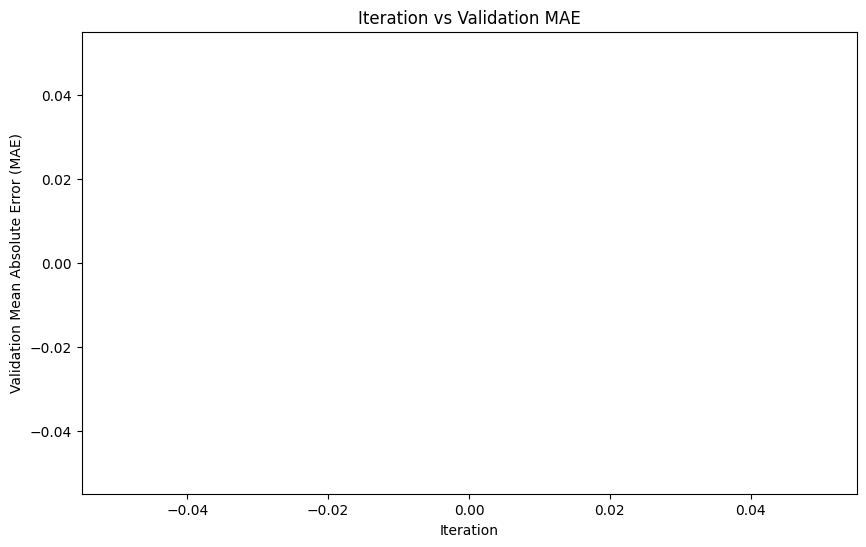

In [5]:
mae_results, raw_results, sorted_index_mae_results  = eureka_agent.get_initial_hypotheses_and_results()



--- LOGGING NEW ACTION ---
Step: 23
Calling function wrapped_read_file(args = (), kwargs = {'file_name': 'eureka/run_0_script_0.py', 'work_dir': 'workspace\\home-data-for-ml-course_branch'})

--- TOOL SUCCESS ---


--- Step: 24 not recorded in history

--- Step Action: Calling function wrapped_read_file(args = (), kwargs = {'file_name': 'eureka/run_0_script_0.py', 'work_dir': '.'})

--- Step Result: {
    "approach_1_analysis": "The first approach uses a RandomForestRegressor model with a predefined set of features. It loads the training data, selects specific features, splits the data into training and validation sets, fits the model, makes predictions, and calculates the Mean Absolute Error (MAE) on the validation set. The model used is a good choice for this regression task, but the feature selection is limited to a few columns only.",
    "approach_2_analysis": "No information provided for Approach / Script 2.",
    "best_pieces_to_form_optimal_code": "To create an optimal model,

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

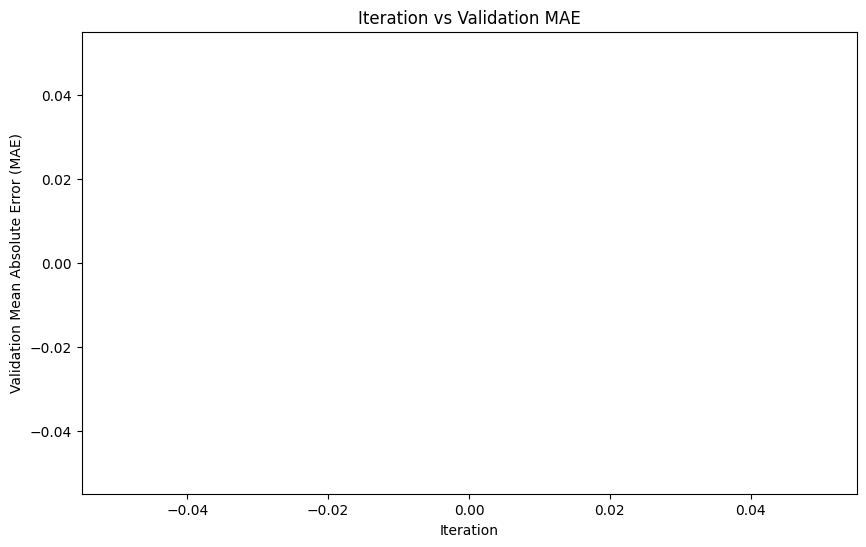

In [8]:
# Run other rounds
NUM_ADDITIONAL_ROUNDS = 1
for _ in range(NUM_ADDITIONAL_ROUNDS):
    eureka_agent.reward_reflection_and_feedback()